# Building chatbot using langgraph

In [1]:
# installations required

# !pip install -qU ipyKernel
# !pip install -qU langgraph
# !pip install -qU typing-extensions
# !pip install -qU "langchain[google-genai]"
# !pip install -qU dotenv
# !pip install -U langchain-tavily

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [3]:
# Building basic chatbot using langgraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages] # annotated helps add metadata to the type. in this case it tells messages should be appended and not overwritten

graph_builder = StateGraph(State)

When defining a graph, the first step is to define its State. The State includes the graph's schema and reducer functions that handle state updates. In our example, State is a schema with one key: messages. The reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values.

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=GEMINI_API_KEY)

In [5]:
llm.invoke("Hello, how are you?")  # basic test to check if llm is working

AIMessage(content="I am doing well, thank you for asking! As a large language model, I don't experience emotions or feelings in the same way humans do, but I am functioning optimally and ready to assist you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--6da7d7ad-5f51-4b59-8b22-1873e40a41a0-0', usage_metadata={'input_tokens': 6, 'output_tokens': 50, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

Notice how the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". This is the basic pattern for all LangGraph node functions.

The add_messages function in our State will append the LLM's response messages to whatever messages are already in the state.

In [7]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

KeyboardInterrupt: 

In [10]:
event_history = []

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        event_history.append(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

/home/aj7/Documents/workspace/github.com/thetsajeet/lab/ai/langgraph/.venv/lib/python3.13/site-packages/langchain_google_genai/chat_models.py:1803: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?


KeyboardInterrupt: 

In [ ]:
from pprint import pprint

pprint(event_history)  # print the entire event history for debugging

[{'chatbot': {'messages': [AIMessage(content='The weather in San Francisco right now is partly cloudy and 63°F. The wind is light, blowing from the west at 6 mph.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--c0cf1caf-bddc-4f83-b4a0-781064b1988f-0', usage_metadata={'input_tokens': 9, 'output_tokens': 32, 'total_tokens': 41, 'input_token_details': {'cache_read': 0}})]}},
 {'chatbot': {'messages': [AIMessage(content="Ah, New York! That's a broad question! To give you the most helpful answer, I need a little more information.  What specifically are you interested in knowing about New York?  For example, are you wondering about:\n\n*   **New York City (NYC)?**\n    *   **Specific boroughs:** Like Manhattan, Brooklyn, Queens, The Bronx, or Staten Island?\n    *   **Things to do:** Tourist attractions, restaurants, nightlife, museums, parks, et

## Adding tools

In [11]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph? - IBM',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making b

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [15]:
from langgraph.prebuilt import ToolNode, tools_condition


graph_builder = StateGraph(State)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()


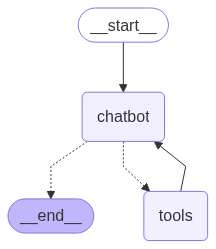

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "what is MCP", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/model-context-protocol", "title": "What is Model Context Protocol (MCP)?", "content": "The Model Context Protocol (MCP) serves as a standardization layer for AI applications to communicate effectively with external services such as tools, databases and predefined templates. MCP allows AI agents to be context-aware while complying with a standardized protocol for tool integration. Regardless, the need for standardized tool integration is critical for AI agents to operate autonomously and adapt dynamically to real-world environments.10 With MCP, we can streamline the automation of complex agentic workflows to allow for less human oversight.In turn, this shift enabled by MCP allows our time to be spent on more nuanced tasks requiring human intellect and intuition.", "score": 0.87218446, "raw_content": null}, {"url": "https://huggi

## Adding Memory

LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

use thread_id to keep track of the chat memory

In [19]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

In [20]:
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

In [21]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config=config):
        event_history.append(event)
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [22]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "new york", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/New_York_City", "title": "New York City - Wikipedia", "content": "The most populous city in the United States. It is located at the southern tip of New York State on one of the world's largest natural harbors.", "score": 0.70944256, "raw_content": null}, {"url": "https://en.wikipedia.org/wiki/New_York_(state)", "title": "New York (state) - Wikipedia", "content": "| Topics \"Outline of New York (state)\") | * Index%E2%80%93related_articles \"Index of New York (state)–related articles\") * Airports \"List of airports in New York (state)\") * Bibliography \"Bibliography of New York (state)\") * Climate change \"Climate change in New York (state)\") * Crime \"Crime in New York (state)\") * Demographics \"Demographics of New York (state)\") * Economy \"Economy of New York (state)\") * Education \"Education in New York (state)\") * Geograp

## Adding human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph's persistence layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the interrupt function. Calling interrupt inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command.

interrupt is ergonomically similar to Python's built-in input()

In [27]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    print("Human response:", human_response)    
    return human_response["data"]

In [25]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

In [29]:
graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

In [38]:
user_input = "search the web for best results on mango?"
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

search the web for best results on mango?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (8364f7c1-c848-4cab-baf9-665fa94dc482)
 Call ID: 8364f7c1-c848-4cab-baf9-665fa94dc482
  Args:
    query: best results on mango
================================= Tool Message =================================
Name: tavily_search

{"query": "best results on mango", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.bbcgoodfood.com/health/nutrition/health-benefits-mango", "title": "Top 5 health benefits of mango", "content": "Top 5 health benefits of mango · 1. Rich in protective antioxidants · 2. May aid digestion · 3. May help maintain healthy skin & hair · 4. May", "score": 0.37882724, "raw_content": null}, {"url": "https://www.healthline.com/nutrition/mango", "title": "Mango: Nutrition, Health Benefits, and How to E

In [39]:
snapshot = graph.get_state(config)
snapshot.next

()

Similar to Python's built-in input() function, calling interrupt inside the tool will pause execution. Progress is persisted based on the checkpointer; so if it is persisting with Postgres, it can resume at any time as long as the database is alive. In this example, it is persisting with the in-memory checkpointer and can resume any time if the Python kernel is running.

In [36]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (0fa7799e-61bf-4013-a2ce-98b76649ae14)
 Call ID: 0fa7799e-61bf-4013-a2ce-98b76649ae14
  Args:
    query: I need expert guidance on building an AI agent.
Human response: {'data': "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents."}
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph to build your AI agent. They say it is more reliable and extensible than simple autonomous agents.
